In [1]:
import os
import time
import numpy as np

import mindspore
from mindspore import nn, ops, context
from mindspore.dataset import Cifar10Dataset, vision, transforms
from mindspore.common.initializer import Normal

# 设置 MindSpore 上下文
# 根据您的环境选择 'Ascend', 'GPU', or 'CPU'
context.set_context(mode=context.GRAPH_MODE, device_target="Ascend")

print(f"MindSpore version: {mindspore.__version__}")

import os
import tarfile
import urllib.request
import mindspore
import mindspore.dataset as ds
import mindspore.dataset.vision as vision
from mindspore.dataset import transforms

def download_and_extract_cifar10(root_path):
    """
    下载并解压 CIFAR-10 数据集，然后整理文件到正确目录。
    
    Args:
        root_path (str): 数据集保存的根目录。
    """
    url = "https://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz"
    filename = "cifar-10-binary.tar.gz"
    filepath = os.path.join(root_path, filename)
    extract_path = os.path.join(root_path, "cifar-10-batches-bin")
    
    # 检查数据集是否已存在并已正确组织
    if os.path.exists(os.path.join(extract_path, 'train')) and os.path.exists(os.path.join(extract_path, 'test')):
        print("数据集已存在并且目录结构正确，跳过下载和整理。")
        return extract_path

    # 创建保存目录
    os.makedirs(root_path, exist_ok=True)

    print(f"开始下载数据集到：{filepath}")
    urllib.request.urlretrieve(url, filepath)
    print("下载完成！")

    # 解压文件
    print(f"开始解压文件到：{root_path}")
    with tarfile.open(filepath, "r:gz") as tar:
        tar.extractall(path=root_path)
    print("解压完成！")

    # 整理文件到正确的 'train' 和 'test' 子目录中
    move_files(extract_path)

    # 删除压缩包
    os.remove(filepath)
    print("压缩包已删除。")

    return extract_path

def move_files(data_dir):
    """
    将解压后的 .bin 文件移动到所需的 'train' 和 'test' 子目录中。
    """
    train_dir = os.path.join(data_dir, 'train')
    test_dir = os.path.join(data_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    print("正在将文件整理到 'train' 和 'test' 文件夹中...")
    for filename in os.listdir(data_dir):
        if filename.startswith('data_batch_') and filename.endswith('.bin'):
            os.rename(os.path.join(data_dir, filename), os.path.join(train_dir, filename))
        elif filename == 'test_batch.bin':
            os.rename(os.path.join(data_dir, filename), os.path.join(test_dir, filename))
    print("文件整理完成！")

def create_dataset_cifar10(dataset_path, batch_size=64, usage='train', is_training=True):
    """
    从指定路径创建 CIFAR-10 数据集。
    
    Args:
        dataset_path (str): 包含数据集文件的目录。
        batch_size (int): 批处理大小。
        usage (str): 数据集用途（'train' 或 'test'）。
        is_training (bool): 是否为训练集。
    """
    dataset = ds.Cifar10Dataset(dataset_path, usage=usage, shuffle=is_training)
    
    trans = []
    if is_training:
        trans += [
            vision.RandomCrop((32, 32), (4, 4, 4, 4)),
            vision.RandomHorizontalFlip(prob=0.5)
        ]

    trans += [
        vision.Resize((224, 224)),
        vision.Rescale(1.0 / 255.0, 0.0),
        vision.Normalize([0.4914, 0.4822, 0.4465], [0.2023, 0.1994, 0.2010]),
        vision.HWC2CHW()
    ]

    target_trans = transforms.TypeCast(mindspore.int32)
    dataset = dataset.map(operations=trans, input_columns="image")
    dataset = dataset.map(operations=target_trans, input_columns="label")
    dataset = dataset.batch(batch_size)
    return dataset

# -----------------------------------------------------------

# 定义数据根目录
DATA_DIR = './datasets'

# 下载、解压并整理数据集
cifar_data_root = download_and_extract_cifar10(DATA_DIR)

# 设置训练和测试集的具体路径
train_data_path = os.path.join(cifar_data_root, 'train')
test_data_path = os.path.join(cifar_data_root, 'test')

# MindSpore 加载数据集
BATCH_SIZE = 64

# 创建训练数据集
train_dataset = create_dataset_cifar10(train_data_path, batch_size=BATCH_SIZE, usage='train', is_training=True)

# 创建测试数据集
test_dataset = create_dataset_cifar10(test_data_path, batch_size=BATCH_SIZE, usage='test', is_training=False)

print("数据集创建完成！")
print(f"训练集大小: {train_dataset.get_dataset_size()}")
print(f"测试集大小: {test_dataset.get_dataset_size()}")

/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:549: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/mindspore/miniconda/envs/jupyter/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


MindSpore version: 2.6.0
数据集已存在并且目录结构正确，跳过下载和整理。
数据集创建完成！
训练集大小: 782
测试集大小: 157


正在可视化训练数据集...


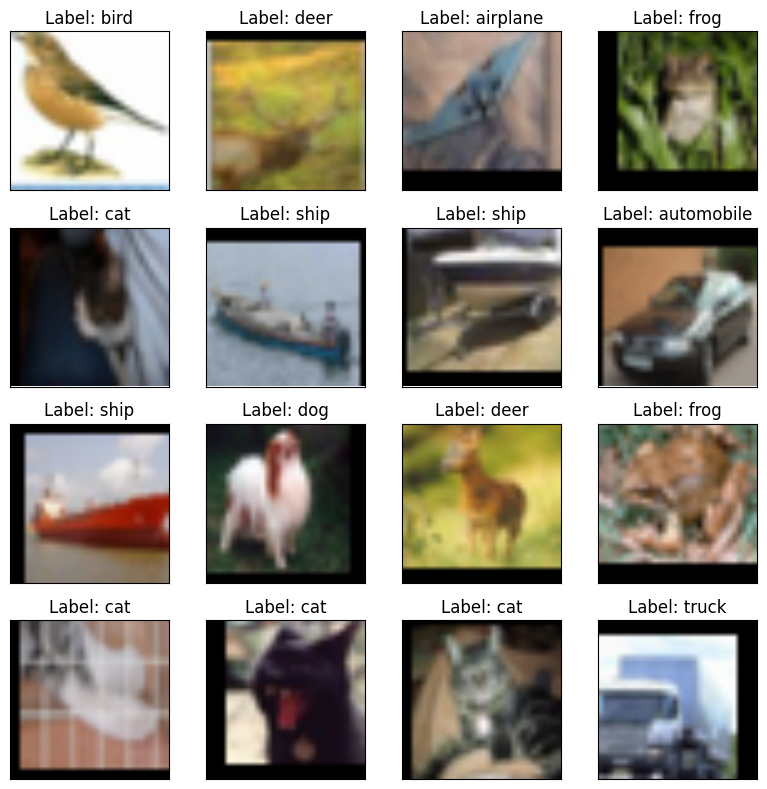

可视化完成！


In [2]:
import matplotlib.pyplot as plt

# 可视化前先反归一化，以便正确显示图像
def denormalize(images):
    """
    对图像进行反归一化处理。
    """
    # 根据你代码中的归一化参数进行反向操作
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2023, 0.1994, 0.2010])
    # 将形状从 (N, C, H, W) 转换到 (N, H, W, C) 以便显示
    images = images.transpose(0, 2, 3, 1)
    images = std * images + mean
    images = np.clip(images, 0, 1)
    return images

# 定义类别标签
labels_map = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# 获取一个批次的数据进行可视化
print("正在可视化训练数据集...")
data_iter = train_dataset.create_tuple_iterator(output_numpy=True, num_epochs=1)
images, labels = next(data_iter)
images_denorm = denormalize(images)

# 可视化前16张图像
fig = plt.figure(figsize=(8, 8))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(images_denorm[i])
    ax.set_title(f"Label: {labels_map[labels[i]]}")

plt.tight_layout()
plt.show()
print("可视化完成！")

In [3]:
from mindvision.classification.models import resnet50
from mindspore import load_checkpoint, load_param_into_net
import mindspore.nn as nn

# 1. 定义教师模型（ResNet-50, 预训练 1000 类）
teacher_net = resnet50(num_classes=1000, pretrained=True)
teacher_net.set_train(False)

# 2. 替换最后一层，改成 CIFAR-10 (10 类)
teacher_net.head = nn.Dense(2048, 10)

# 3. 定义冻结包装类，只做前向推理，不注册参数
class FrozenTeacher(nn.Cell):
    def __init__(self, net):
        super(FrozenTeacher, self).__init__()
        self.net = net
        self.net.set_train(False)  # 保证冻结

    def construct(self, x):
        return self.net(x)

# 4. 用 FrozenTeacher 包装教师模型
teacher_net = FrozenTeacher(teacher_net)

print("教师模型 (ResNet-50, 预训练+改为10类, 冻结包装完成) 定义完成！")

# 这里我们直接使用 mindspore.nn 中定义的 ResNet-18 结构
from mindvision.classification.models import resnet18

student_net = resnet18(num_classes=10, pretrained=False)

print("学生模型 (ResNet-18) 定义完成！")

教师模型 (ResNet-50, 预训练+改为10类, 冻结包装完成) 定义完成！
学生模型 (ResNet-18) 定义完成！


..Epoch [1/20] Train Loss: 0.9080, Val Loss: 0.8528, Val Acc: 0.6096
Epoch [2/20] Train Loss: 0.7663, Val Loss: 0.7817, Val Acc: 0.6929
Epoch [3/20] Train Loss: 0.6968, Val Loss: 0.6964, Val Acc: 0.7741
Epoch [4/20] Train Loss: 0.6587, Val Loss: 0.7086, Val Acc: 0.7606
Epoch [5/20] Train Loss: 0.6322, Val Loss: 0.6417, Val Acc: 0.8213
Epoch [6/20] Train Loss: 0.6132, Val Loss: 0.6238, Val Acc: 0.8413
Epoch [7/20] Train Loss: 0.5978, Val Loss: 0.6082, Val Acc: 0.8569
Epoch [8/20] Train Loss: 0.5830, Val Loss: 0.5921, Val Acc: 0.8707
Epoch [9/20] Train Loss: 0.5733, Val Loss: 0.6265, Val Acc: 0.8346
Epoch [10/20] Train Loss: 0.5615, Val Loss: 0.5859, Val Acc: 0.8774
Epoch [11/20] Train Loss: 0.5547, Val Loss: 0.5736, Val Acc: 0.8938
Epoch [12/20] Train Loss: 0.5461, Val Loss: 0.5660, Val Acc: 0.8986
Epoch [13/20] Train Loss: 0.5396, Val Loss: 0.5703, Val Acc: 0.8927
Epoch [14/20] Train Loss: 0.5338, Val Loss: 0.5625, Val Acc: 0.8971
Epoch [15/20] Train Loss: 0.5271, Val Loss: 0.5527, Val

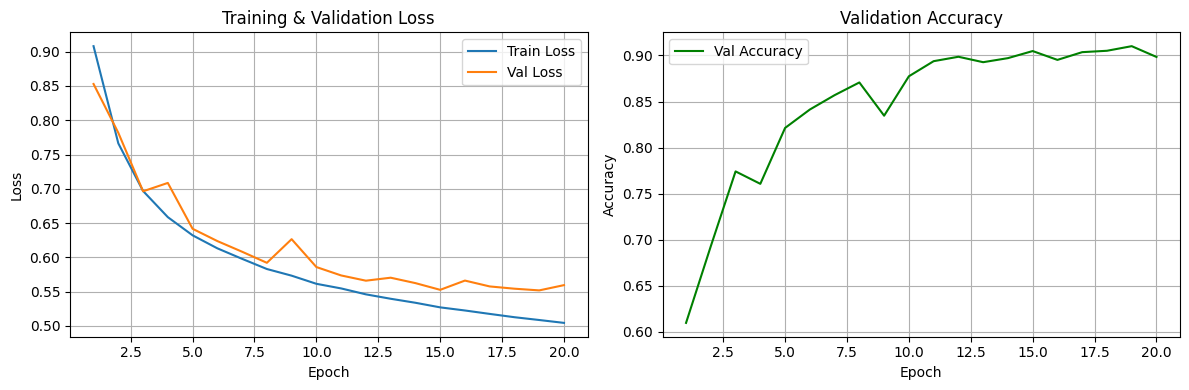

In [4]:
# ----------------- 损失函数 -----------------
class AdaptiveKDLoss(nn.Cell):
    """
    一个包含硬标签损失和软标签损失的知识蒸馏损失函数。
    """
    def __init__(self, temperature=3.0, alpha=0.5):
        super(AdaptiveKDLoss, self).__init__()
        self.temperature = temperature
        self.alpha = alpha
        self.ce_loss = nn.CrossEntropyLoss(reduction='mean')
        self.kl_div_loss = nn.KLDivLoss(reduction='batchmean')
        self.log_softmax = nn.LogSoftmax(axis=1)
        self.softmax = nn.Softmax(axis=1)

    def construct(self, student_logits, teacher_logits, labels):
        # 硬标签损失 (交叉熵)
        loss_ce = self.ce_loss(student_logits, labels)
        
        # 软标签损失 (KL 散度)
        teacher_soft_labels = self.softmax(teacher_logits / self.temperature)
        student_soft_preds = self.log_softmax(student_logits / self.temperature)

        # 使用 ops.stop_gradient 确保教师模型的梯度不被计算
        loss_kd = self.kl_div_loss(student_soft_preds, ops.stop_gradient(teacher_soft_labels))
        
        # 综合损失
        total_loss = self.alpha * loss_ce + (1 - self.alpha) * loss_kd * (self.temperature ** 2)
        
        return total_loss
    
# ----------------- 训练单元 -----------------
class AKD_WithLossCell(nn.Cell):
    """
    一个封装了学生模型和损失函数的Cell。
    """
    def __init__(self, student_net, teacher_net, loss_fn):
        super(AKD_WithLossCell, self).__init__(auto_prefix=False)
        self.student_net = student_net
        self.teacher_net = teacher_net
        self.loss_fn = loss_fn
        self.teacher_net.set_train(False)
    
    def construct(self, images, labels):
        student_logits = self.student_net(images)
        teacher_logits = self.teacher_net(images)
        loss = self.loss_fn(student_logits, teacher_logits, labels)
        return loss

# 实例化训练单元和优化器
loss_fn = AdaptiveKDLoss(temperature=3.0, alpha=0.5)
optimizer = nn.Adam(student_net.trainable_params(), learning_rate=0.0001)

# 将新的WithLossCell和优化器传递给MindSpore内置的TrainOneStepCell
net_with_loss = AKD_WithLossCell(student_net, teacher_net, loss_fn)
train_step = nn.TrainOneStepCell(net_with_loss, optimizer)

#   训练与评估主循环
num_epochs = 20
train_losses, val_losses, val_accs = [], [], []

for epoch in range(num_epochs):
    # ---- Training ----
    train_step.set_train(True)
    total_loss, step_count = 0, 0
    
    for images, labels in train_dataset.create_tuple_iterator():
        loss = train_step(images, labels)
        total_loss += loss.asnumpy()
        step_count += 1
    avg_train_loss = total_loss / step_count
    train_losses.append(avg_train_loss)

    # ---- Validation ----
    student_net.set_train(False)
    total_loss, correct, total = 0, 0, 0
    
    for images, labels in test_dataset.create_tuple_iterator():
        logits = student_net(images)
        teacher_logits = teacher_net(images)
        loss = loss_fn(logits, teacher_logits, labels)
        total_loss += loss.asnumpy()
        
        preds = logits.asnumpy().argmax(axis=1)
        correct += (preds == labels.asnumpy()).sum()
        total += labels.shape[0]
        
    avg_val_loss = total_loss / test_dataset.get_dataset_size()
    val_losses.append(avg_val_loss)
    val_acc = correct / total
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}")
    
import matplotlib.pyplot as plt

#   可视化绘图

epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 4))

# ---- 训练/验证损失 ----
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# ---- 验证精度 ----
plt.subplot(1, 2, 2)
plt.plot(epochs, val_accs, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

正在抽取小批量数据进行分类可视化...


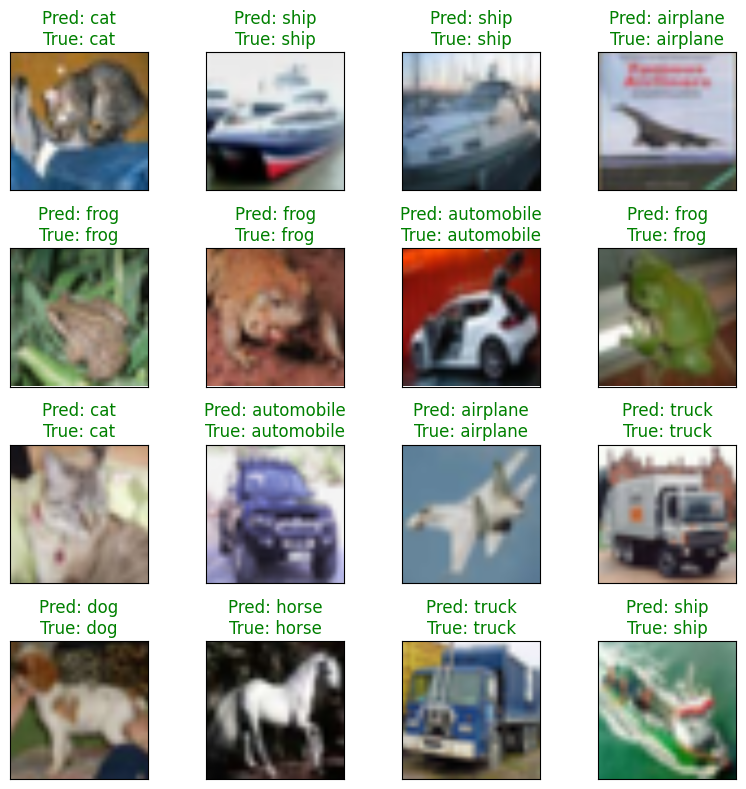

正在进行大批量测试...
模型在整个测试集上的最终准确度: 0.8984
评估完成！


In [5]:
# 设置学生模型为评估模式
student_net.set_train(False)

# 获取一个批次的测试数据
print("正在抽取小批量数据进行分类可视化...")
test_iter = test_dataset.create_tuple_iterator(output_numpy=True, num_epochs=1)
images_test, labels_test = next(test_iter)

# 进行推理
logits = student_net(mindspore.Tensor(images_test))
preds = logits.asnumpy().argmax(axis=1)

# 可视化预测结果
images_denorm_test = denormalize(images_test)
fig = plt.figure(figsize=(8, 8))
for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    color = "green" if preds[i] == labels_test[i] else "red"
    title = f"Pred: {labels_map[preds[i]]}\nTrue: {labels_map[labels_test[i]]}"
    ax.imshow(images_denorm_test[i])
    ax.set_title(title, color=color)

plt.tight_layout()
plt.show()

# 进行大批量测试，计算最终准确度
print("正在进行大批量测试...")
total_correct, total_count = 0, 0
for images, labels in test_dataset.create_tuple_iterator():
    logits = student_net(images)
    preds = logits.asnumpy().argmax(axis=1)
    correct = (preds == labels.asnumpy()).sum()
    total_correct += correct
    total_count += labels.shape[0]

final_acc = total_correct / total_count
print(f"模型在整个测试集上的最终准确度: {final_acc:.4f}")
print("评估完成！")

In [6]:
# 1. 定义教师模型（ResNet-50, 预训练 1000 类）
teacher_net = resnet50(num_classes=1000, pretrained=True)
teacher_net.set_train(False)

# 2. 替换最后一层，改成 CIFAR-10 (10 类)
teacher_net.head = nn.Dense(2048, 10)

# 3. 定义冻结包装类，只做前向推理，不注册参数
class FrozenTeacher(nn.Cell):
    def __init__(self, net):
        super(FrozenTeacher, self).__init__()
        self.net = net
        self.net.set_train(False)  # 保证冻结

    def construct(self, x):
        return self.net(x)

# 4. 用 FrozenTeacher 包装教师模型
teacher_net = FrozenTeacher(teacher_net)

print("教师模型 (ResNet-50, 预训练+改为10类, 冻结包装完成) 定义完成！")

# 这里我们直接使用 mindspore.nn 中定义的 ResNet-18 结构
from mindvision.classification.models import resnet18

student_net = resnet18(num_classes=10, pretrained=False)

print("学生模型 (ResNet-18) 定义完成！")

教师模型 (ResNet-50, 预训练+改为10类, 冻结包装完成) 定义完成！
学生模型 (ResNet-18) 定义完成！


[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-12:25:25.902.445 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3898655016.py]


.

[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-12:27:23.373.919 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3898655016.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-12:27:30.968.302 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3898655016.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-12:27:30.968.385 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3898655016.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-12:27:53.696.136 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3898655016.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-12:27:53.696.219 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3898655016.py]


Epoch [1/20] Train Loss: 1.0398, Val Loss: 0.8973, Val Acc: 0.6644, Alpha: 0.6140
Epoch [2/20] Train Loss: 0.8253, Val Loss: 0.8908, Val Acc: 0.6745, Alpha: 0.5977
Epoch [3/20] Train Loss: 0.7390, Val Loss: 0.7829, Val Acc: 0.7434, Alpha: 0.5810
Epoch [4/20] Train Loss: 0.6879, Val Loss: 0.7358, Val Acc: 0.7554, Alpha: 0.5636
Epoch [5/20] Train Loss: 0.6495, Val Loss: 0.6818, Val Acc: 0.8056, Alpha: 0.5453
Epoch [6/20] Train Loss: 0.6203, Val Loss: 0.6529, Val Acc: 0.8161, Alpha: 0.5266
Epoch [7/20] Train Loss: 0.5949, Val Loss: 0.6070, Val Acc: 0.8450, Alpha: 0.5074
Epoch [8/20] Train Loss: 0.5731, Val Loss: 0.5971, Val Acc: 0.8512, Alpha: 0.4881
Epoch [9/20] Train Loss: 0.5559, Val Loss: 0.5730, Val Acc: 0.8657, Alpha: 0.4686
Epoch [10/20] Train Loss: 0.5383, Val Loss: 0.5547, Val Acc: 0.8810, Alpha: 0.4491
Epoch [11/20] Train Loss: 0.5221, Val Loss: 0.5506, Val Acc: 0.8703, Alpha: 0.4297
Epoch [12/20] Train Loss: 0.5078, Val Loss: 0.5275, Val Acc: 0.8828, Alpha: 0.4105
Epoch [13/20]

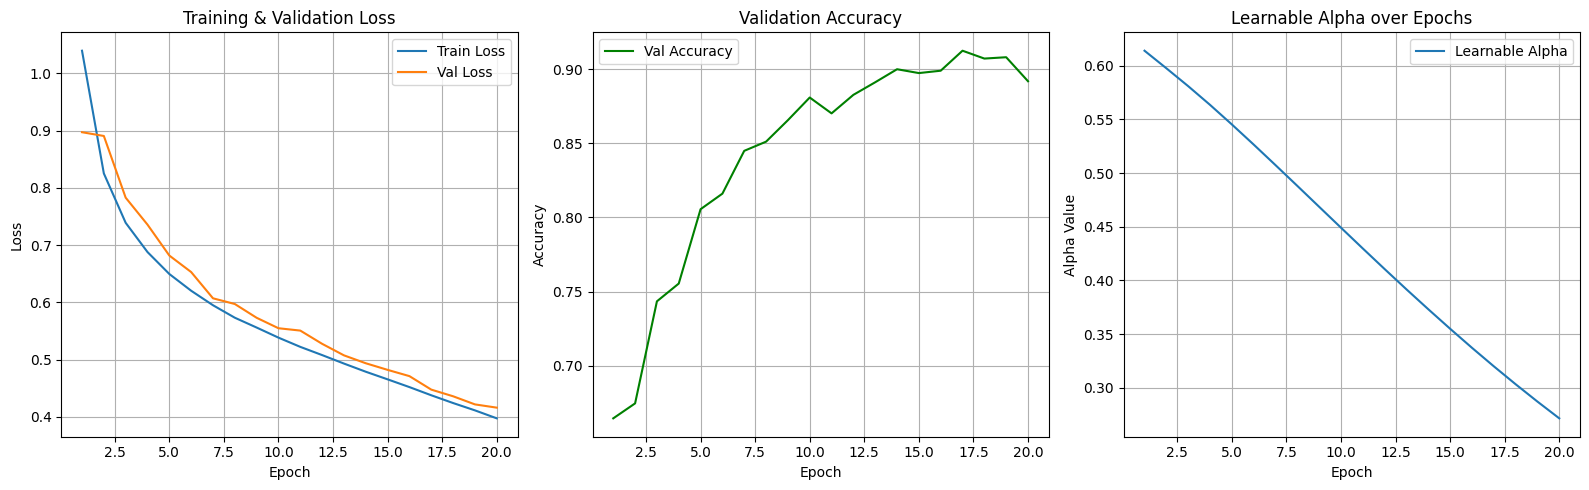

In [ ]:
import mindspore as ms
from mindspore import nn, ops, Tensor
import matplotlib.pyplot as plt

# =========================
# 1. LearnableAlpha 模块
# =========================
class LearnableAlpha(nn.Cell):
    """α 作为可学习参数，自动在训练中优化"""
    def __init__(self, init_value=0.5):
        super(LearnableAlpha, self).__init__()
        self.alpha = ms.Parameter(Tensor(init_value, ms.float32), name="alpha")
        self.sigmoid = nn.Sigmoid()

    def construct(self):
        return self.sigmoid(self.alpha)

# =========================
# 2. 改造后的 AdaptiveKDLoss
# =========================
class AdaptiveKDLoss(nn.Cell):
    """
    硬标签损失 + 软标签损失，α 为可学习参数
    """
    def __init__(self, temperature=3.0):
        super(AdaptiveKDLoss, self).__init__()
        self.temperature = temperature
        self.ce_loss = nn.CrossEntropyLoss(reduction='mean')
        self.kl_div_loss = nn.KLDivLoss(reduction='batchmean')
        self.log_softmax = nn.LogSoftmax(axis=1)
        self.softmax = nn.Softmax(axis=1)
        self.alpha_module = LearnableAlpha(init_value=0.5)

    def construct(self, student_logits, teacher_logits, labels):
        loss_ce = self.ce_loss(student_logits, labels)
        teacher_soft_labels = self.softmax(teacher_logits / self.temperature)
        student_soft_preds = self.log_softmax(student_logits / self.temperature)
        loss_kd = self.kl_div_loss(student_soft_preds, ops.stop_gradient(teacher_soft_labels))
        alpha = self.alpha_module()
        total_loss = alpha * loss_ce + (1 - alpha) * loss_kd * (self.temperature ** 2)
        return total_loss, alpha

# =========================
# 3. WithLossCell
# =========================
class AKD_WithLossCell(nn.Cell):
    def __init__(self, student_net, teacher_net, loss_fn):
        super(AKD_WithLossCell, self).__init__(auto_prefix=False)
        self.student_net = student_net
        self.teacher_net = teacher_net
        self.loss_fn = loss_fn
        self.teacher_net.set_train(False)

    def construct(self, images, labels):
        student_logits = self.student_net(images)
        teacher_logits = self.teacher_net(images)
        loss, alpha = self.loss_fn(student_logits, teacher_logits, labels)
        return loss, alpha

# =========================
# 4. 实例化训练单元和优化器
# =========================

loss_fn = AdaptiveKDLoss(temperature=3.0)
optimizer = nn.Adam(
    list(student_net.trainable_params()) + list(loss_fn.trainable_params()),
    learning_rate=0.0001
)
net_with_loss = AKD_WithLossCell(student_net, teacher_net, loss_fn)
train_step = nn.TrainOneStepCell(net_with_loss, optimizer)

# =========================
# 5. 训练与评估主循环
# =========================
num_epochs = 20
train_losses, val_losses, val_accs, alphas = [], [], [], []

for epoch in range(num_epochs):
    # ---- Training ----
    train_step.set_train(True)
    total_loss, total_alpha, step_count = 0, 0, 0
    
    for images, labels in train_dataset.create_tuple_iterator():
        # Correctly unpack the tuple from train_step
        loss, alpha = train_step(images, labels)
        total_loss += loss.asnumpy()
        total_alpha += alpha.asnumpy()
        step_count += 1
    
    avg_train_loss = total_loss / step_count
    avg_alpha = total_alpha / step_count
    train_losses.append(avg_train_loss)
    alphas.append(avg_alpha)

    # ---- Validation ----
    student_net.set_train(False)
    total_loss, correct, total = 0, 0, 0
    
    for images, labels in test_dataset.create_tuple_iterator():
        logits = student_net(images)
        teacher_logits = teacher_net(images)
        # Unpack the tuple from loss_fn, even if alpha isn't used
        loss, _ = loss_fn(logits, teacher_logits, labels)
        total_loss += loss.asnumpy()
        
        preds = logits.asnumpy().argmax(axis=1)
        correct += (preds == labels.asnumpy()).sum()
        total += labels.shape[0]
        
    avg_val_loss = total_loss / test_dataset.get_dataset_size()
    val_losses.append(avg_val_loss)
    val_acc = correct / total
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Alpha: {avg_alpha:.4f}")

# =========================
# 6. 可视化绘图
# =========================
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(16, 5))

# ---- Loss 曲线 ----
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# ---- Val Acc 曲线 ----
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accs, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

# ---- Alpha 曲线 ----
plt.subplot(1, 3, 3)
plt.plot(epochs, alphas, label="Learnable Alpha")
plt.xlabel("Epoch")
plt.ylabel("Alpha Value")
plt.title("Learnable Alpha over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [4]:
# 1. 定义教师模型（ResNet-50, 预训练 1000 类）
teacher_net = resnet50(num_classes=1000, pretrained=True)
teacher_net.set_train(False)

# 2. 替换最后一层，改成 CIFAR-10 (10 类)
teacher_net.head = nn.Dense(2048, 10)

# 3. 定义冻结包装类，只做前向推理，不注册参数
class FrozenTeacher(nn.Cell):
    def __init__(self, net):
        super(FrozenTeacher, self).__init__()
        self.net = net
        self.net.set_train(False)  # 保证冻结

    def construct(self, x):
        return self.net(x)

# 4. 用 FrozenTeacher 包装教师模型
teacher_net = FrozenTeacher(teacher_net)

print("教师模型 (ResNet-50, 预训练+改为10类, 冻结包装完成) 定义完成！")

# 这里我们直接使用 mindspore.nn 中定义的 ResNet-18 结构
from mindvision.classification.models import resnet18

student_net = resnet18(num_classes=10, pretrained=False)

print("学生模型 (ResNet-18) 定义完成！")

教师模型 (ResNet-50, 预训练+改为10类, 冻结包装完成) 定义完成！
学生模型 (ResNet-18) 定义完成！


[ERROR] CORE(18835,ffff840bf020,python3.9):2025-08-29-10:15:29.905.404 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_18835/2392944894.py]


.

[ERROR] CORE(18835,ffff840bf020,python3.9):2025-08-29-10:17:57.691.014 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_18835/2392944894.py]


.

[ERROR] CORE(18835,ffff840bf020,python3.9):2025-08-29-10:18:06.237.065 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_18835/2392944894.py]
[ERROR] CORE(18835,ffff840bf020,python3.9):2025-08-29-10:18:29.119.900 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_18835/2392944894.py]


Epoch [1/20] Train Loss: 0.9785, Val Loss: 0.8809, Val Acc: 0.5555, Alpha: 0.4924
Epoch [2/20] Train Loss: 0.8163, Val Loss: 0.8458, Val Acc: 0.6135, Alpha: 0.4851
Epoch [3/20] Train Loss: 0.7280, Val Loss: 0.7581, Val Acc: 0.7038, Alpha: 0.4807
Epoch [4/20] Train Loss: 0.6721, Val Loss: 0.7640, Val Acc: 0.7008, Alpha: 0.4779
Epoch [5/20] Train Loss: 0.6394, Val Loss: 0.6727, Val Acc: 0.7786, Alpha: 0.4761
Epoch [6/20] Train Loss: 0.6160, Val Loss: 0.6780, Val Acc: 0.7885, Alpha: 0.4749
Epoch [7/20] Train Loss: 0.5962, Val Loss: 0.6108, Val Acc: 0.8504, Alpha: 0.4739
Epoch [8/20] Train Loss: 0.5827, Val Loss: 0.5995, Val Acc: 0.8588, Alpha: 0.4732
Epoch [9/20] Train Loss: 0.5684, Val Loss: 0.5879, Val Acc: 0.8684, Alpha: 0.4725
Epoch [10/20] Train Loss: 0.5574, Val Loss: 0.5710, Val Acc: 0.8846, Alpha: 0.4719
Epoch [11/20] Train Loss: 0.5466, Val Loss: 0.5792, Val Acc: 0.8723, Alpha: 0.4714
Epoch [12/20] Train Loss: 0.5378, Val Loss: 0.5616, Val Acc: 0.8928, Alpha: 0.4710
Epoch [13/20]

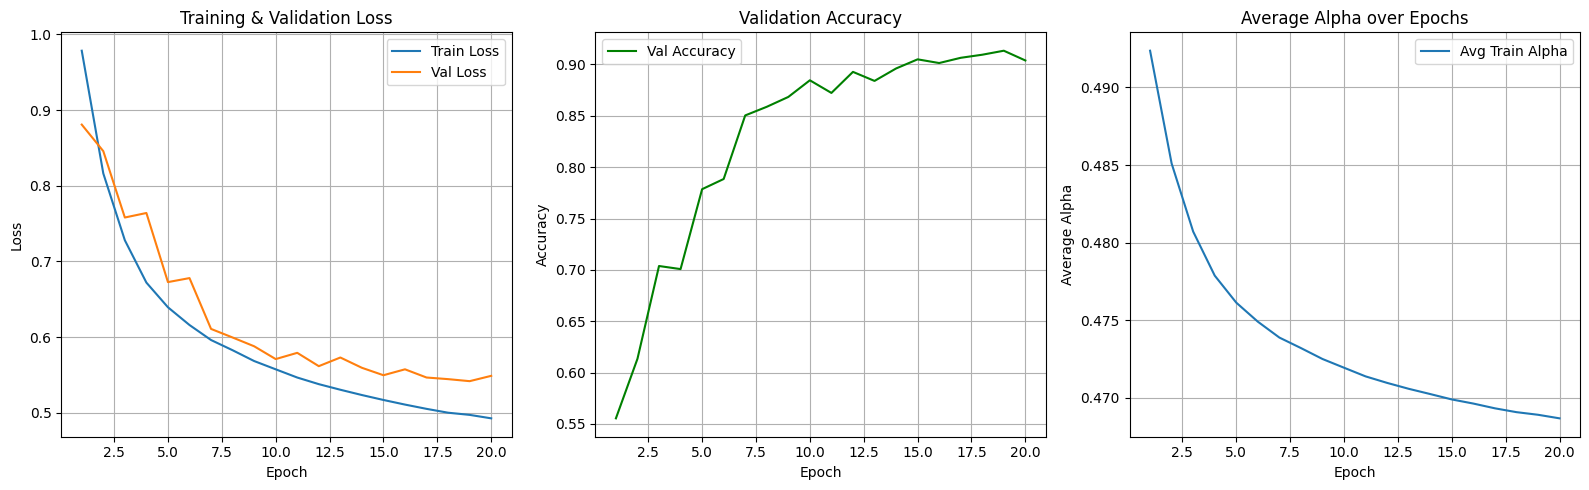

In [5]:
import mindspore as ms
from mindspore import Tensor, nn, ops
import matplotlib.pyplot as plt

# 动态 α 的 KD Loss (直接 Sigmoid 映射)
class AdaptiveKDLoss(nn.Cell):
    """
    硬标签损失 + 软标签损失
    α 根据 student 和 teacher 的输出差距动态调整
    """
    def __init__(self, temperature=3.0, k=5.0):
        super(AdaptiveKDLoss, self).__init__()
        self.temperature = temperature
        self.k = k  # 控制曲线陡峭程度
        self.ce_loss = nn.CrossEntropyLoss(reduction='mean')
        self.kl_div_loss = nn.KLDivLoss(reduction='batchmean')
        self.log_softmax = nn.LogSoftmax(axis=1)
        self.softmax = nn.Softmax(axis=1)

    def construct(self, student_logits, teacher_logits, labels):
        # ---- 硬标签损失 ----
        loss_ce = self.ce_loss(student_logits, labels)

        # ---- 软标签损失 ----
        teacher_soft = self.softmax(teacher_logits / self.temperature)
        student_soft = self.log_softmax(student_logits / self.temperature)
        loss_kd = self.kl_div_loss(student_soft, ops.stop_gradient(teacher_soft))

        # ---- 动态 α ----
        # 用概率差距衡量 student vs teacher
        student_prob = self.softmax(student_logits)
        teacher_prob = self.softmax(teacher_logits)
        dist = ops.mean((student_prob - ops.stop_gradient(teacher_prob)) ** 2)
        # Sigmoid 映射到 (0,1)
        alpha = ops.sigmoid(-self.k * dist)

        # ---- 综合损失 ----
        total_loss = alpha * loss_ce + (1 - alpha) * loss_kd * (self.temperature ** 2)
        return total_loss, alpha


# WithLossCell 封装

class AKD_WithLossCell(nn.Cell):
    def __init__(self, student_net, teacher_net, loss_fn):
        super(AKD_WithLossCell, self).__init__(auto_prefix=False)
        self.student_net = student_net
        self.teacher_net = teacher_net
        self.loss_fn = loss_fn
        self.teacher_net.set_train(False)
    
    def construct(self, images, labels):
        student_logits = self.student_net(images)
        teacher_logits = self.teacher_net(images)
        loss, alpha = self.loss_fn(student_logits, teacher_logits, labels)
        return loss, alpha

loss_fn = AdaptiveKDLoss(temperature=3.0, k=5.0)
optimizer = nn.Adam(student_net.trainable_params(), learning_rate=0.001)
net_with_loss = AKD_WithLossCell(student_net, teacher_net, loss_fn)
train_step = nn.TrainOneStepCell(net_with_loss, optimizer)


num_epochs = 20
train_losses, val_losses, val_accs, alphas = [], [], [], []

for epoch in range(num_epochs):
    # ---- Training ----
    train_step.set_train(True)
    total_loss, total_alpha, step_count = 0, 0, 0
    
    for images, labels in train_dataset.create_tuple_iterator():
        loss, alpha = train_step(images, labels)
        total_loss += loss.asnumpy()
        total_alpha += alpha.asnumpy()
        step_count += 1
    avg_train_loss = total_loss / step_count
    avg_alpha = total_alpha / step_count
    train_losses.append(avg_train_loss)
    alphas.append(avg_alpha)

    # ---- Validation ----
    student_net.set_train(False)
    total_loss, correct, total = 0, 0, 0
    
    for images, labels in test_dataset.create_tuple_iterator():
        logits = student_net(images)
        teacher_logits = teacher_net(images)
        loss, _ = loss_fn(logits, teacher_logits, labels)
        total_loss += loss.asnumpy()
        
        preds = logits.asnumpy().argmax(axis=1)
        correct += (preds == labels.asnumpy()).sum()
        total += labels.shape[0]
        
    avg_val_loss = total_loss / test_dataset.get_dataset_size()
    val_losses.append(avg_val_loss)
    val_acc = correct / total
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Alpha: {avg_alpha:.4f}")

# 可视化绘图

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(16, 5))

# ---- Loss 曲线 ----
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# ---- Val Acc 曲线 ----
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accs, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

# ---- Alpha 曲线 ----
plt.subplot(1, 3, 3)
plt.plot(epochs, alphas, label="Avg Train Alpha")
plt.xlabel("Epoch")
plt.ylabel("Average Alpha")
plt.title("Average Alpha over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [6]:
# 1. 定义教师模型（ResNet-50, 预训练 1000 类）
teacher_net = resnet50(num_classes=1000, pretrained=True)
teacher_net.set_train(False)

# 2. 替换最后一层，改成 CIFAR-10 (10 类)
teacher_net.head = nn.Dense(2048, 10)

# 3. 定义冻结包装类，只做前向推理，不注册参数
class FrozenTeacher(nn.Cell):
    def __init__(self, net):
        super(FrozenTeacher, self).__init__()
        self.net = net
        self.net.set_train(False)  # 保证冻结

    def construct(self, x):
        return self.net(x)

# 4. 用 FrozenTeacher 包装教师模型
teacher_net = FrozenTeacher(teacher_net)

print("教师模型 (ResNet-50, 预训练+改为10类, 冻结包装完成) 定义完成！")

# 这里我们直接使用 mindspore.nn 中定义的 ResNet-18 结构
from mindvision.classification.models import resnet18

student_net = resnet18(num_classes=10, pretrained=False)

print("学生模型 (ResNet-18) 定义完成！")

教师模型 (ResNet-50, 预训练+改为10类, 冻结包装完成) 定义完成！
学生模型 (ResNet-18) 定义完成！


[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:40:23.071.662 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3342027681.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:40:23.079.951 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3342027681.py]


..

[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:42:53.915.079 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3342027681.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:42:53.923.535 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3342027681.py]


.

[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:43:02.473.138 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3342027681.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:43:02.473.224 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3342027681.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:43:02.473.481 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3342027681.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:43:25.529.532 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3342027681.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:43:25.529.634 [mindspore/core/utils/file_utils.cc:253] GetRealPath] Get realpath failed, path[/tmp/ipykernel_32740/3342027681.py]
[ERROR] CORE(32740,ffff9b96e020,python3.9):2025-08-29-11:43:25.52

Epoch [1/20] Train Loss: 0.9953, Val Loss: 0.9107, Val Acc: 0.5365, Alpha: 0.4916
Epoch [2/20] Train Loss: 0.8350, Val Loss: 0.8139, Val Acc: 0.6407, Alpha: 0.4847
Epoch [3/20] Train Loss: 0.7412, Val Loss: 0.7604, Val Acc: 0.7073, Alpha: 0.4802
Epoch [4/20] Train Loss: 0.6858, Val Loss: 0.7064, Val Acc: 0.7490, Alpha: 0.4774
Epoch [5/20] Train Loss: 0.6491, Val Loss: 0.6476, Val Acc: 0.8059, Alpha: 0.4755
Epoch [6/20] Train Loss: 0.6250, Val Loss: 0.6452, Val Acc: 0.7978, Alpha: 0.4743
Epoch [7/20] Train Loss: 0.6038, Val Loss: 0.6099, Val Acc: 0.8530, Alpha: 0.4732
Epoch [8/20] Train Loss: 0.5889, Val Loss: 0.6047, Val Acc: 0.8490, Alpha: 0.4724
Epoch [10/20] Train Loss: 0.5637, Val Loss: 0.5837, Val Acc: 0.8749, Alpha: 0.4712
Epoch [11/20] Train Loss: 0.5533, Val Loss: 0.5695, Val Acc: 0.8910, Alpha: 0.4707
Epoch [12/20] Train Loss: 0.5450, Val Loss: 0.5754, Val Acc: 0.8844, Alpha: 0.4702
Epoch [13/20] Train Loss: 0.5364, Val Loss: 0.5669, Val Acc: 0.8886, Alpha: 0.4698
Epoch [14/20

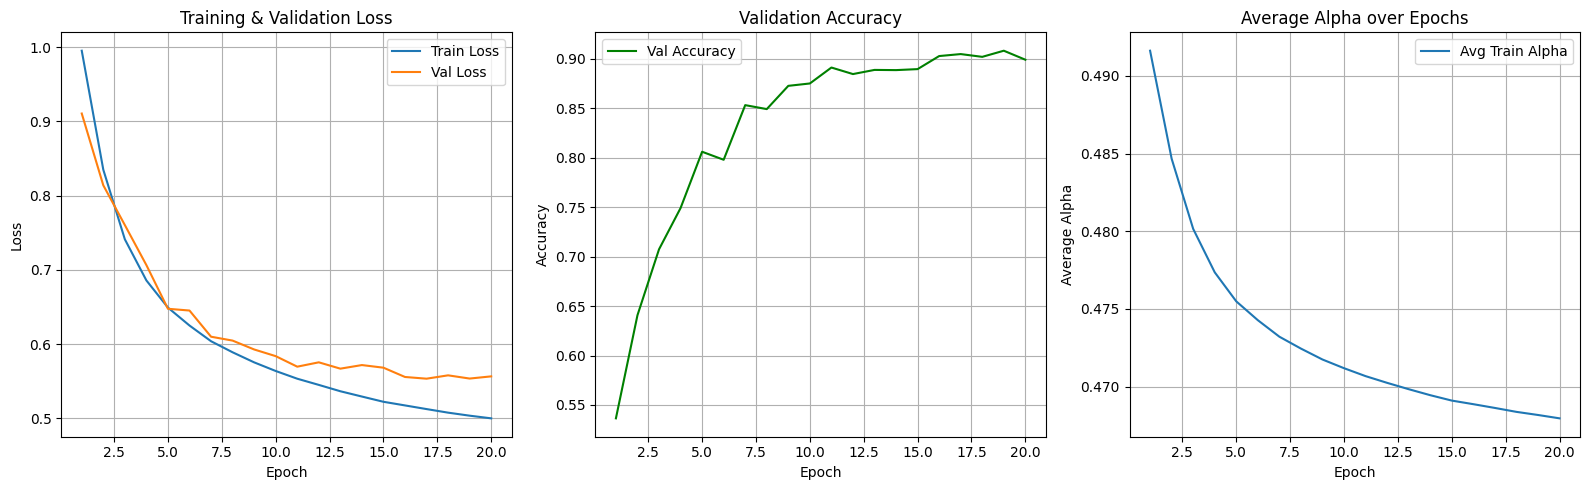

In [ ]:
import mindspore as ms
from mindspore import Tensor, nn, ops
import matplotlib.pyplot as plt

# =========================
# 1. 上下文感知模块 (MLP + Attention)
# =========================
class ContextualModule(nn.Cell):
    """
    输入: student_logits, teacher_logits
    输出: 权重向量 (batch, num_classes)
    结构: MLP + Attention
    """
    def __init__(self, num_classes, hidden_dim=128):
        super(ContextualModule, self).__init__()
        self.concat = ops.Concat(axis=1)
        self.abs = ops.Abs()
        
        # MLP 加深 + BatchNorm 稳定训练
        self.fc1 = nn.Dense(num_classes * 3, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.fc2 = nn.Dense(hidden_dim, hidden_dim)
        self.fc3 = nn.Dense(hidden_dim, num_classes)
        
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def construct(self, student_logits, teacher_logits):
        gap = self.abs(student_logits - teacher_logits)   # 差异特征
        x = self.concat((student_logits, teacher_logits, gap))
        
        x = self.relu(self.bn1(self.fc1(x)))
        x = self.relu(self.fc2(x))
        attn = self.fc3(x)
        attn = self.sigmoid(attn)  # 注意力 ∈ [0,1]
        return attn


# =========================
# 2. Context-aware KD Loss + 动态 α (不缩放)
# =========================
class ContextAwareKDLoss(nn.Cell):
    """
    硬标签损失 + 上下文感知软标签损失
    α 根据 student 与 teacher 的输出差距动态调整 (Sigmoid)
    """
    def __init__(self, num_classes, temperature=3.0, k=4.0):
        super(ContextAwareKDLoss, self).__init__()
        self.temperature = temperature
        self.k = k

        self.ce_loss = nn.CrossEntropyLoss(reduction='mean')
        self.kl_div_loss = nn.KLDivLoss(reduction='batchmean')
        self.log_softmax = nn.LogSoftmax(axis=1)
        self.softmax = nn.Softmax(axis=1)
        self.cm = ContextualModule(num_classes)

        self.reduce_sum = ops.ReduceSum(keep_dims=True)
        self.reduce_mean = ops.ReduceMean()

    def construct(self, student_logits, teacher_logits, labels):
        # ---- 硬标签损失 ----
        loss_ce = self.ce_loss(student_logits, labels)

        # ---- 上下文感知教师 soft 标签 ----
        teacher_soft = self.softmax(teacher_logits / self.temperature)
        attn = self.cm(student_logits, teacher_logits)
        teacher_soft_context = teacher_soft * attn
        teacher_soft_context = teacher_soft_context / self.reduce_sum(teacher_soft_context, (1,))

        # ---- 软标签损失 ----
        student_soft = self.log_softmax(student_logits / self.temperature)
        loss_kd = self.kl_div_loss(student_soft, ops.stop_gradient(teacher_soft_context))

        # ---- 动态 α (Sigmoid 映射) ----
        student_prob = self.softmax(student_logits)
        teacher_prob = self.softmax(teacher_logits)
        dist_per_sample = self.reduce_mean((student_prob - ops.stop_gradient(teacher_prob)) ** 2, (1,))
        dist = self.reduce_mean(dist_per_sample, (0,))
        alpha = ops.sigmoid(-self.k * dist)

        # ---- 综合损失 ----
        total_loss = alpha * loss_ce + (1 - alpha) * loss_kd * (self.temperature ** 2)
        return total_loss, alpha


# =========================
# 3. WithLossCell 封装
# =========================
class AKD_WithLossCell(nn.Cell):
    def __init__(self, student_net, teacher_net, loss_fn):
        super(AKD_WithLossCell, self).__init__(auto_prefix=False)
        self.student_net = student_net
        self.teacher_net = teacher_net
        self.loss_fn = loss_fn
        self.teacher_net.set_train(False)

    def construct(self, images, labels):
        student_logits = self.student_net(images)
        teacher_logits = self.teacher_net(images)
        loss, alpha = self.loss_fn(student_logits, teacher_logits, labels)
        return loss, alpha

num_classes = 10
loss_fn = ContextAwareKDLoss(num_classes=num_classes, temperature=3.0, k=4.0)
optimizer = nn.Adam(student_net.trainable_params(), learning_rate=0.001)

net_with_loss = AKD_WithLossCell(student_net, teacher_net, loss_fn)
train_step = nn.TrainOneStepCell(net_with_loss, optimizer)


# =========================
# 5. 训练与验证循环
# =========================
num_epochs = 20
train_losses, val_losses, val_accs, alphas = [], [], [], []

for epoch in range(num_epochs):
    train_step.set_train(True)
    total_loss, total_alpha, step_count = 0, 0, 0

    for images, labels in train_dataset.create_tuple_iterator():
        loss, alpha = train_step(images, labels)
        total_loss += loss.asnumpy()
        total_alpha += alpha.asnumpy()
        step_count += 1
    avg_train_loss = total_loss / step_count
    avg_alpha = total_alpha / step_count
    train_losses.append(avg_train_loss)
    alphas.append(avg_alpha)

    student_net.set_train(False)
    total_loss, correct, total = 0, 0, 0

    for images, labels in test_dataset.create_tuple_iterator():
        logits = student_net(images)
        teacher_logits = teacher_net(images)
        loss, _ = loss_fn(logits, teacher_logits, labels)
        total_loss += loss.asnumpy()

        preds = logits.asnumpy().argmax(axis=1)
        correct += (preds == labels.asnumpy()).sum()
        total += labels.shape[0]

    avg_val_loss = total_loss / test_dataset.get_dataset_size()
    val_losses.append(avg_val_loss)
    val_acc = correct / total
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, "
          f"Val Acc: {val_acc:.4f}, "
          f"Alpha: {avg_alpha:.4f}")


# =========================
# 6. 可视化绘图
# =========================
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(16, 5))

# ---- Loss 曲线 ----
plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)

# ---- Val Acc 曲线 ----
plt.subplot(1, 3, 2)
plt.plot(epochs, val_accs, label="Val Accuracy", color="green")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy")
plt.legend()
plt.grid(True)

# ---- Alpha 曲线 ----
plt.subplot(1, 3, 3)
plt.plot(epochs, alphas, label="Avg Train Alpha")
plt.xlabel("Epoch")
plt.ylabel("Average Alpha")
plt.title("Average Alpha over Epochs")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()